In [4]:
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
import pickle
import time


# Constants
IMG_DIMS = (120, 120, 3)  # Image dimensions
BATCH_SIZE = 30  # Batch size
DATA_DIR = r'C:/Users/User/Desktop/Project/Classifier/gender_data'  # Path to the dataset directory

# Initialize lists to hold image data and labels
data = []
labels = []

# Load images and labels
print("Loading and processing images...")
image_files = [f for f in glob.glob(DATA_DIR + '/**/*', recursive=True) if not os.path.isdir(f)]
for img in image_files:
    image = cv2.imread(img)
    if image is None:
        print(f"Could not read the image: {img}")
        continue  # Skip unreadable files

    # Preprocess image
    image = cv2.resize(image, (IMG_DIMS[0], IMG_DIMS[1]))
    image = img_to_array(image)
    data.append(image)

    # Assign label based on folder name
    label = img.split(os.path.sep)[-2]
    label = 1 if label == 'woman' else 0
    labels.append(label)

# Convert data and labels to numpy arrays
data = np.array(data, dtype='float32') / 255.0  # Normalize pixel values
labels = np.array(labels)

# Summary
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

# Split dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# Print dataset summaries
print(f"trainX shape: {trainX.shape}, dtype: {trainX.dtype}")
print(f"trainY shape: {trainY.shape}, dtype: {trainY.dtype}")
print(f"testX shape: {testX.shape}, dtype: {testX.dtype}")
print(f"testY shape: {testY.shape}, dtype: {testY.dtype}")

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).batch(BATCH_SIZE).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(BATCH_SIZE).repeat()

# Data augmentation
train_gen = ImageDataGenerator(
    brightness_range=[0.8, 1.5],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

test_gen = ImageDataGenerator()

# Flow from directory for augmented data (used for example, optional)
print("Generating augmented training and testing data...")
training_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(120, 120),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
testing_data = test_gen.flow_from_directory(
    DATA_DIR,
    target_size=(120, 120),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Print class indices for reference
print("Class indices (training):", training_data.class_indices)
print("Class indices (testing):", testing_data.class_indices)

# Label distribution summary
unique, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")

# Save the class mapping
Train_class = training_data.class_indices

Result_class = {value: key for key, value in Train_class.items()}

# Save the mapping to a file using pickle

output_path = 'C:/Users/User/Desktop/Project/Classifier/ResultMap.pkl'

# Save the mapping to the specified path
with open(output_path, 'wb') as Final_mapping:
    pickle.dump(Result_class, Final_mapping)


print(f"Mapping saved to: {output_path}")

print("Mapping of numeric labels to class names:", Result_class)

# Calculate the number of output neurons
Output_Neurons = len(Result_class)
print(f"Number of output neurons: {Output_Neurons}")

# Label distribution summary
unique, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")



base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_DIMS,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])


#Initializing the Convolutional Neural Network
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_DIMS),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),  # Flatten only after all Conv2D layers
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

#Perform Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Or binary_crossentropy for 1 output unit
    metrics=['accuracy']
)


# Using Early stopping to reduce the training time


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=8,          # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Revert to the best weights
)




# Define ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=3,          # Wait for 3 epochs of no improvement
    min_lr=1e-6          # Set a minimum learning rate
)


# After splitting the dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((testX, testY))
val_dataset = val_dataset.batch(BATCH_SIZE).repeat()



history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_steps=len(testX) // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)



Loading and processing images...
Data shape: (1552, 120, 120, 3)
Labels shape: (1552,)
Label distribution: {np.int64(0): np.int64(776), np.int64(1): np.int64(776)}
trainX shape: (1241, 120, 120, 3), dtype: float32
trainY shape: (1241, 2), dtype: float64
testX shape: (311, 120, 120, 3), dtype: float32
testY shape: (311, 2), dtype: float64
Generating augmented training and testing data...
Found 1463 images belonging to 2 classes.
Found 1463 images belonging to 2 classes.
Class indices (training): {'man': 0, 'woman': 1}
Class indices (testing): {'man': 0, 'woman': 1}
Label distribution: {np.int64(0): np.int64(776), np.int64(1): np.int64(776)}
Mapping saved to: C:/Users/User/Desktop/Project/Classifier/ResultMap.pkl
Mapping of numeric labels to class names: {0: 'man', 1: 'woman'}
Number of output neurons: 2
Label distribution: {np.int64(0): np.int64(776), np.int64(1): np.int64(776)}


C:\Users\User\AppData\Local\Temp\ipykernel_2280\2685453979.py:136: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.6133 - loss: 3.2582 - val_accuracy: 0.5067 - val_loss: 2.1059 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.6522 - loss: 2.0099 - val_accuracy: 0.7433 - val_loss: 1.5682 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.6995 - loss: 1.3855 - val_accuracy: 0.7133 - val_loss: 1.2721 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.7669 - loss: 1.0252 - val_accuracy: 0.6567 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8244 - loss: 0.8459 - val_accuracy: 0.5133 - val_loss: 1.1451 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.8666 - loss: 0.6948 - val_accuracy: 0.6067 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.8855 - loss: 0

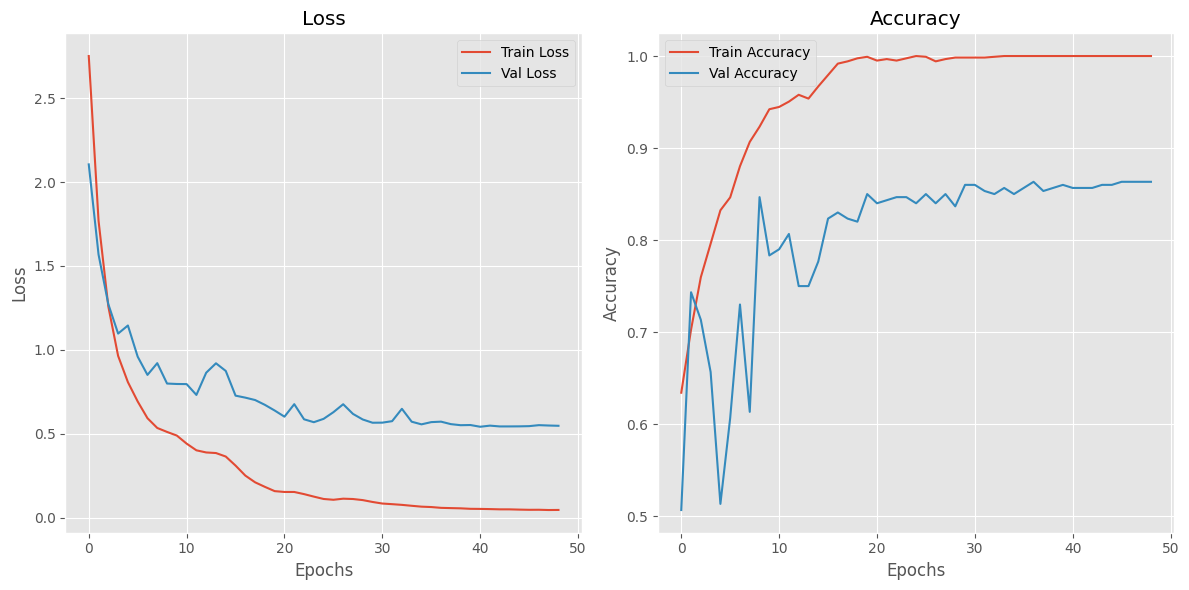

In [5]:
history.history

import matplotlib.pyplot as plt
import numpy as np

# Plot loss and accuracy
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()



In [6]:
model.save('gender_model.h5')
